In [3]:
import pprint
import sys

import numpy as np
import pandas as pd
import math
from sklearn.model_selection import KFold

data = pd.read_csv("C:/Users/user/BBM409/assignment2/dataset.csv")

data = data.drop(["EmployeeNumber"],axis=1)

def grouping(column):
    mx = np.amax(column)
    mn = np.amin(column)

    intr = (mx - mn + 1) / 10

    column -= mn
    column /= intr
    column = column.astype(int)

    return column



liste = ["Age", "DailyRate", "DistanceFromHome", "HourlyRate", "MonthlyIncome", "MonthlyRate", "PercentSalaryHike",
         "TotalWorkingYears", "YearsAtCompany"
    , "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]

for i in liste:
    data[i] = grouping(data[i])

data = data.iloc[:]
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,5,Yes,Travel_Rarely,7,Sales,0,2,Life Sciences,1,2,...,1,80,0,1,0,1,1,2,0,2
1,7,No,Travel_Frequently,1,Research & Development,2,1,Life Sciences,1,3,...,4,80,1,2,3,3,2,3,0,3
2,4,Yes,Travel_Rarely,9,Research & Development,0,2,Other,1,4,...,2,80,0,1,3,3,0,0,0,0
3,3,No,Travel_Frequently,9,Research & Development,0,4,Life Sciences,1,4,...,3,80,0,1,3,3,1,3,1,0
4,2,No,Travel_Rarely,3,Research & Development,0,1,Medical,1,1,...,4,80,1,1,3,3,0,1,1,1


In [4]:
def total_entropy(data,target):
    amountOfYes = data[target].value_counts()["Yes"]
    amountOfNo = data[target].value_counts()["No"]
    total = amountOfNo + amountOfYes
    return (-1 * (amountOfNo/total) * math.log2(amountOfNo/total)) + (-1 * (amountOfYes/total) * math.log2(amountOfYes/total))



def class_entropy(feature_data,attr,result_list):
    count = len(feature_data)
    entropy = 0
    for a in result_list:
        counter = len(feature_data[feature_data[attr] == a])
        cl_entropy = 0
        if(counter > 0):
            cl_entropy = -1 * (counter/count) * math.log2(counter/count)
        entropy += cl_entropy

    return entropy


def class_gain(name,data,attr,result_list):
    categories = data[name].unique()
    c = 0.0
    for cat in categories:
        spec_data = data[data[name] == cat]
        cl_entropy = class_entropy(spec_data,attr,result_list)
        tmp = (len(spec_data)/len(data)) * cl_entropy
        c -= tmp

    return total_entropy(data,attr) + c

def max_gain(data,attr,result_list):
    listt = data.columns.drop(attr)
    mx = -1*(math.inf)
    mxfeature = None

    for a in listt:
        temp = class_gain(a,data,attr,result_list)
        if(temp > mx):
            mx = temp
            mxfeature = a
    return mxfeature

def create_branch(name,data,attr,result_list):
    dict = data[name].value_counts(sort=False)
    tree = {}

    for feature_value,count in dict.items():
        feature_value_data = data[data[name] == feature_value]

        assigned_to_node = False  #Pure class checker
        for c in result_list:
            class_count = len(feature_value_data[feature_value_data[attr] == c])

            if class_count == count:
                tree[feature_value] = c
                data = data[data[name] !=  feature_value]  #Deleting leafs on the dataset.
                assigned_to_node = True
            if not assigned_to_node:
                tree[feature_value] = "?"

    return tree,data

def make_tree(root,prev,data,attr,result_list):
    if(len(data) > 0):
        max_gain_feature = max_gain(data,attr,result_list)
        tree,data = create_branch(max_gain_feature,data,attr,result_list)

        if prev == None:
            root[max_gain_feature] = tree
            next_root = root[max_gain_feature]
        else:
            root[prev] =  dict()
            root[prev][max_gain_feature] = tree
            next_root = root[prev][max_gain_feature]
        for node,branch in list(next_root.items()):
            if branch == "?":
                feature_value_data = data[data[max_gain_feature] == node]
                make_tree(next_root,node,feature_value_data,attr,result_list)

def decision_Tree(firstData,attr):
    data = firstData.copy()
    result_list = data[attr].unique()
    tree = {}
    make_tree(tree,None,data,attr,result_list)
    return tree


def func(tree, attrition):
    res = []
    for a,row in attrition.iterrows():
        element = pre(tree,row)
        res.append(element)
    return res

def pre(tree,row):
    node = list(tree.keys())[0]
    try:
        branch  = tree[node][row[node]]
    except Exception:
        return None
    if(isinstance(branch,str)):
        return branch
    else:
        return pre(branch,row)

def rules(path,tree,counter):
    for k,v in tree.items():
        if counter ==0:
            if isinstance(v,dict):
                rules("("+k,v,counter+1)

        elif counter%2==0:

            if isinstance(v,dict):
                rules(path+" ^ ("+k,v,counter+1)
            else:
                print(path+"="+k,"=>",v)



        else:

            if isinstance(v,dict):
                rules(path+"="+k+")",v,counter+1)
            else:
                print(path+"="+k+")","=>",v)




In [5]:
kfold = KFold(5,shuffle=True)
y=(data["Attrition"])
x = data.astype(str)
testSize = len(x)/5

table = np.zeros([6,4])

counter =0
maxaccuracy = 0
besttree = dict
for training_index, testing_index in kfold.split(data):
    X_train, X_test = x.iloc[training_index,:], x.iloc[testing_index,:]
    Y_test =  y.iloc[testing_index]
    tree = decision_Tree(X_train,"Attrition")
    predict = (func(tree, X_test))
   
    (tp,fp,tn,fn) = (0,0,0,0)
    for a in range(len(predict)):
        if(predict[a] == "Yes" and Y_test[testing_index[a]] == "Yes"):
            tp += 1
        elif(predict[a] == "Yes" and Y_test[testing_index[a]] == "No"):
            fp += 1
        elif(predict[a] == "No" and Y_test[testing_index[a]] == "No"):
            tn += 1
        elif(predict[a] == "No" and Y_test[testing_index[a]] == "Yes"):
            fn += 1
    accuracy = (tp+tn) / (tp+fp+fn+tn)
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = (2 * (recall * precision)) / (recall+precision)
    table[counter][0]=accuracy
    table[counter][1]=precision
    table[counter][2]=recall
    table[counter][3]=f1
    if accuracy > maxaccuracy:
        maxaccuracy = accuracy
        besttree = tree
    counter+=1
    
table[5]=np.mean(table,axis=0)
table[5]*=6/5
tabledataframe= pd.DataFrame(table,columns=["Accuracy","Precision","Recall","F1 Score"],index= ["Fold 1","Fold 2","Fold 3","Fold 4","Fold 5","Average"])

rules("",besttree,0)

(JobRole=Sales Executive) ^ (StockOptionLevel=0) ^ (NumCompaniesWorked=8) ^ (DailyRate=7) ^ (Age=5) => Yes
(JobRole=Sales Executive) ^ (StockOptionLevel=0) ^ (NumCompaniesWorked=8) ^ (DailyRate=7) ^ (Age=9) => No
(JobRole=Sales Executive) ^ (StockOptionLevel=0) ^ (NumCompaniesWorked=8) ^ (DailyRate=9) => Yes
(JobRole=Sales Executive) ^ (StockOptionLevel=0) ^ (NumCompaniesWorked=8) ^ (DailyRate=6) => No
(JobRole=Sales Executive) ^ (StockOptionLevel=0) ^ (NumCompaniesWorked=8) ^ (DailyRate=1) => Yes
(JobRole=Sales Executive) ^ (StockOptionLevel=0) ^ (NumCompaniesWorked=8) ^ (DailyRate=8) => No
(JobRole=Sales Executive) ^ (StockOptionLevel=0) ^ (NumCompaniesWorked=8) ^ (DailyRate=5) => No
(JobRole=Sales Executive) ^ (StockOptionLevel=0) ^ (NumCompaniesWorked=0) ^ (DailyRate=6) => No
(JobRole=Sales Executive) ^ (StockOptionLevel=0) ^ (NumCompaniesWorked=0) ^ (DailyRate=4) => No
(JobRole=Sales Executive) ^ (StockOptionLevel=0) ^ (NumCompaniesWorked=0) ^ (DailyRate=3) ^ (Age=7) => No
(JobRol

# CONCLUSION
**Why did we group by 10?**

Because, it was appropriate for features which has long range. We tried grouping by 7 and grouping by 5 but accuracy hasn't been effected appreciable. 

### Grouping by 10

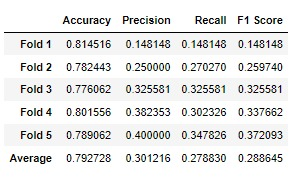

### Grouping by 7
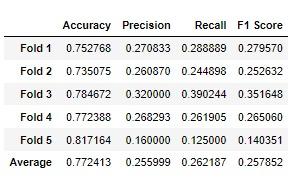


### Grouping by 5
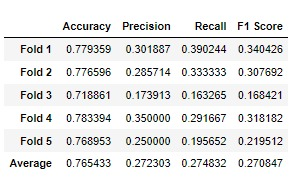

**Comment**

We executed the code many times and we got usually average of accuracy between 0.77-0.79 .
Precision and recall are not stable as much as accuracy because they depend on false positive/false negative. F1 score changes too,because it's formula contains precision and recall.They all depend on the shuffled data.

**Where we had difficulty in assignment?**

We had a hard time creating a decision tree.